In [7]:
params = {}
params['dataset'] = 'inat_2018'  # inat_2018, inat_2017, birdsnap, nabirds, yfcc
if params['dataset'] in ['birdsnap', 'nabirds']:
    params['meta_type'] = 'ebird_meta'  # orig_meta, ebird_meta
else:
    params['meta_type'] = ''
params['batch_size'] = 1024
params['lr'] = 0.0005
params['lr_decay'] = 0.98
params['num_filts'] = 256  # embedding dimension
params['num_epochs'] = 30
params['log_frequency'] = 50
params['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
params['balanced_train_loader'] = True
params['max_num_exs_per_class'] = 100
params['map_range'] = (-180, 180, -90, 90)

# specify feature encoding for location and date
params['use_date_feats'] = True  # if False date feature is not used
params['loc_encode']     = 'encode_cos_sin'  # encode_cos_sin, encode_3D, encode_none
params['date_encode']    = 'encode_cos_sin' # encode_cos_sin, encode_none

# specify loss type
# appending '_user' models the user location and object affinity - see losses.py
params['train_loss'] = 'full_loss_user'  # full_loss_user, full_loss

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import decomposition

import sys
sys.path.append('../')
from geo_prior import models
from geo_prior.paths import get_paths
import geo_prior.datasets as dt
import geo_prior.grid_predictor as grid

Computing features.


/home/sm9669/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Saving images to: images/map_ims/


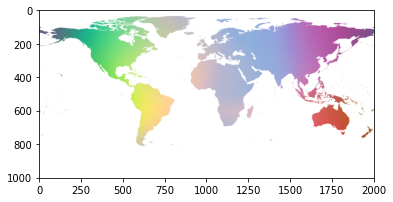

In [9]:
"""
Extracts features from a trained network for each geo location (and time), performs
dimensionality reduction, and generates an output image.
"""




# model_path = '../models/model_inat_2018_full_final.pth.tar'
num_time_steps = 12
num_ds_dims = 3
seed = 2001
op_dir = 'images/map_ims/'
if not os.path.isdir(op_dir):
    os.makedirs(op_dir)


# load model
model_path = '/scratch/sm9669/nabird pickle/FCNET_50_.pth'
net_params = torch.load(model_path, map_location='cpu')
# params = net_params['params']
model = models.FCNet(num_inputs=6, num_classes=555,
                     num_filts=256, num_users=1).to(params['device'])

model.load_state_dict(net_params)
model.eval()

# load ocean mask
mask = np.load(get_paths('mask_dir') + 'ocean_mask.npy')

# grid predictor - for making dense predictions for each lon/lat location
gp = grid.GridPredictor(mask, params, mask_only_pred=True)

# compute intermediate network features
print('Computing features.')
feats = []
for time_step in np.linspace(0,1,num_time_steps+1)[:-1]:
    net_feats = gp.dense_prediction_masked_feats(model, time_step).data.cpu().numpy()
    feats.append(net_feats)


# downsample features - choose middle time step
dsf = decomposition.FastICA(n_components=num_ds_dims, random_state=seed)
dsf.fit(feats[len(feats) // 2])

op_ims = []
mask_inds = np.where(mask.ravel() == 1)[0]
mins = []
maxes = []
for ii in range(len(feats)):
    feats_ds = dsf.transform(feats[ii])

    # convert into image
    op_im = np.ones((mask.shape[0]*mask.shape[1], num_ds_dims))
    op_im[mask_inds] = feats_ds
    mins.append(op_im[mask_inds].min())
    maxes.append(op_im[mask_inds].max())
    op_ims.append(op_im)

# normalize to same range
min_val = np.min(mins)
max_val = (np.max(maxes) - min_val)
for ii in range(len(op_ims)):
    op_ims[ii][mask_inds] -= min_val
    op_ims[ii][mask_inds] /= max_val

for ii in range(len(op_ims)):
    op_ims[ii] = op_ims[ii].reshape((mask.shape[0], mask.shape[1], num_ds_dims))

print('Saving images to: ' + op_dir)
for ii in range(len(op_ims)):
    plt.imsave(op_dir + 'map_im_' + str(ii).zfill(3) + '.png', (op_ims[ii]*255).astype(np.uint8))

plt.close('all')
plt.figure(0)
plt.imshow(op_ims[len(op_ims)//2])
plt.show()

